# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Apoptosis-and-hypoxia:" data-toc-modified-id="Apoptosis-and-hypoxia:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Apoptosis and hypoxia:</a></div><div class="lev1 toc-item"><a href="#Anoxia-Responses:" data-toc-modified-id="Anoxia-Responses:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anoxia Responses:</a></div><div class="lev1 toc-item"><a href="#HIF-1-Independent-Genes-are-not-independent:-Padmanabha-Genetics-2015:" data-toc-modified-id="HIF-1-Independent-Genes-are-not-independent:-Padmanabha-Genetics-2015:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HIF-1 Independent Genes are not independent: Padmanabha Genetics 2015:</a></div><div class="lev1 toc-item"><a href="#Hydroxylated-hif-1-Targets:" data-toc-modified-id="Hydroxylated-hif-1-Targets:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hydroxylated hif-1 Targets:</a></div><div class="lev1 toc-item"><a href="#Plotting-HIF-1-Hydroxyl-Downstream-Targets:" data-toc-modified-id="Plotting-HIF-1-Hydroxyl-Downstream-Targets:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting HIF-1 Hydroxyl Downstream Targets:</a></div>

In [ ]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)


# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize

In [ ]:
import genpy
import gvars
import morgan as morgan
import seqplotter

In [3]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [4]:
genvar = gvars.genvars()

In [5]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

In [6]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [7]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genvar.fancy_mapping[key]
    frames += [df]

tidy_data = pd.concat(frames)

In [8]:
def find_expression(gene, col='ext_gene', q=0.1, df=tidy_data):
    """Given a gene, find out what genotypes it is DE in."""
    
    results = df[(df[col] == gene) & (df.qval < q)]

    if len(results) > len(results.code.unique()):
        print('Warning: This gene has multiple isoforms.')
        
    return df[(df[col] == gene) & (df.qval < q)]

In [9]:
def print_deg(diff_exp_gene):
    """A fancy print function for a dataframe."""
    if len(diff_exp_gene) > 0:
        print(diff_exp_gene.ext_gene.unique()[0])
        if len(diff_exp_gene.target_id.unique()) == 1:
            print(diff_exp_gene[['genotype', 'b', 'qval']])
        else:
            print(diff_exp_gene[['genotype', 'target_id', 'b', 'qval']])

    else:
        print('Dataframe is Empty')

# Apoptosis and hypoxia:

In [10]:
diff_exp_gene = find_expression('tyr-2')
print_deg(diff_exp_gene)

tyr-2
                 genotype         b          qval
17624        \emph{egl-9}  3.651982  5.633134e-25
17624        \emph{rhy-1}  3.229023  3.238141e-19
17624  \emph{egl-9;vhl-1}  3.786888  7.255251e-27
17624        \emph{vhl-1}  1.218582  1.442717e-02


# Anoxia Responses:

In [11]:
diff_exp_gene = find_expression('san-1', col='ext_gene')
print_deg(diff_exp_gene)

san-1
                 genotype         b      qval
31245        \emph{egl-9}  0.265445  0.029947
31245  \emph{egl-9;vhl-1}  0.328116  0.002990


In [12]:
diff_exp_gene = find_expression('hyl-2', col='ext_gene')
print_deg(diff_exp_gene)

hyl-2
                 genotype         b      qval
16870        \emph{egl-9} -0.370397  0.005276
16870  \emph{egl-9;vhl-1} -0.266925  0.071218


# HIF-1 Independent Genes are not independent: Padmanabha Genetics 2015:

In [13]:
diff_exp_gene = find_expression('WBGene00009724', col='ens_gene')
print_deg(diff_exp_gene)

F45D3.4
                 genotype         b          qval
13251        \emph{egl-9}  1.506708  7.149037e-06
13251        \emph{fog-2} -0.841871  3.570030e-02
13251        \emph{rhy-1}  1.668968  5.264177e-07
13251  \emph{egl-9;vhl-1}  1.662158  4.242760e-07


In [14]:
diff_exp_gene = find_expression('mnk-1', col='ext_gene')
print_deg(diff_exp_gene)

mnk-1
                 genotype target_id         b      qval
20346        \emph{egl-9}   R166.5a  0.485370  0.039070
20346        \emph{hif-1}   R166.5a  0.615076  0.014443
20347        \emph{hif-1}   R166.5b  0.506439  0.040089
20346        \emph{fog-2}   R166.5a -0.692041  0.000599
20346        \emph{rhy-1}   R166.5a  0.651213  0.001610
20346  \emph{egl-9;vhl-1}   R166.5a  0.483184  0.034564


In [15]:
diff_exp_gene = find_expression('icl-1', col='ext_gene')
print_deg(diff_exp_gene)

icl-1
                genotype         b      qval
1717  \emph{egl-9;hif-1} -1.047181  0.027856
1717  \emph{egl-9;vhl-1} -0.940495  0.016402


In [16]:
df1 = thomas.beta['f'].copy()
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] 
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b

df1['se_b_c'] = df2.se_b
df1['se_b_e'] = df3.se_b
df1['se_b_b'] = df4.se_b
df1['se_b_a'] = df5.se_b
df1['se_b_d'] = df6.se_b

df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

# Hydroxylated hif-1 Targets:

In [17]:
n = 1


hifsig = ((df1.qval < 10**-n) &
          (df1.q_b < 10**-n) &
          (df1.q_c < 10**-n) &
          (df1.q_d < 10**-n) &
          (df1.q_a < 10**-n)
         )

hif = ((df1.b_b*df1.b_c > 0) &  # hif matches egl
       (df1.b_b*df1.b_d < 0) &  # egl anti vhl
       (df1.b_b*df1.b > 0)   &  # egl matches eglhif
       (df1.b_b*df1.b_a > 0)    # egl matches eglvhl
      ) 


rhy = ((df1.b_e*df1.b_c > 0) &  # rhy matches hif
       (df1.b_e*df1.b_d < 0) &  # rhy anti vhl
       (df1.b_e*df1.b > 0)   &  # rhy matches eglhif
       (df1.b_e*df1.b_a > 0)    # rhy matches eglvhl
      )

rhysig = ((df1.qval < 10**-n) & 
          (df1.q_e < 10**-n) &
          (df1.q_c < 10**-n) &
          (df1.q_d < 10**-n) &
          (df1.q_a < 10**-n)
         )


# lower confidence genes:
lowhif = ((df1.b_b*df1.b_c > 0) &  # hif matches egl
          (df1.b_b*df1.b_d < 0) &  # egl anti vhl
          (df1.b_b*df1.b > 0)      # egl matches eglhif
         )

lowsighif = ((df1.qval < 10**-n) &
             (df1.q_b < 10**-n)  &
             (df1.q_c < 10**-n)  &
             (df1.q_d < 10**-n)
            )
 
lowrhy = ((df1.b_e*df1.b_c > 0) &  # hif matches egl
          (df1.b_e*df1.b_d < 0) &  # egl anti vhl
          (df1.b_e*df1.b > 0)      # egl matches eglhif
         )

lowsigrhy = ((df1.qval < 10**-n) &  # eglhif sig
        (df1.q_e < 10**-n)  &  # egl sig
        (df1.q_c < 10**-n)  &  # hif sig
        (df1.q_d < 10**-n)     # vhl sig
       )


lowegl = ((df1.b_b*df1.b_c > 0) &  # hif matches egl
          (df1.b_b*df1.b_d < 0) &  # egl anti vhl
          (df1.b_b*df1.b > 0)      # egl matches eglhif
         )

lowsigegl = ((df1.qval < 10**-n) &
             (df1.q_b < 10**-n)  &
             (df1.q_c < 10**-n)  &
             (df1.q_d < 10**-n)
            )

# even lower confidence genes
lowerrhy = (
            (df1.b_e*df1.b_d < 0) &  # egl anti vhl
            (df1.b_e*df1.b_a > 0)      # egl matches eglvhl
           )

lowersigrhy = ((df1.q_a < 10**-n) &  # eglhif sig
        (df1.q_e < 10**-n)  &  # egl sig
        (df1.q_d < 10**-n)     # vhl sig
       )


loweregl = (
            (df1.b_b*df1.b_d < 0) &  # egl anti vhl
            (df1.b_b*df1.b_a > 0)      # egl matches eglvhl
           )

lowersigegl = ((df1.q_a < 10**-n) &  # eglhif sig
        (df1.q_b < 10**-n)  &  # egl sig
        (df1.q_d < 10**-n)     # vhl sig
       )

In [18]:
# use least strict conditions:
lowestrhy = (df1.b_e*df1.b_d < 0)  # egl anti vhl

lowestsigrhy = ((df1.q_e < 10**-n) &  # egl sig
                (df1.q_d < 10**-n))   # vhl sig
               

lowestegl = (df1.b_b*df1.b_d < 0)  # egl anti vhl


lowestsigegl = ((df1.q_b < 10**-n) &  # egl sig
                (df1.q_d < 10**-n))   # vhl sig

In [19]:
sorter = {'a': 5,
          'f': 6,
          'b': 2,
          'c': 4,
          'd': 3,
          'e': 1,
          'g': 7
         }

df1.sort_values('q_c', ascending=True)

hifoh = df1[
        (lowestegl & lowestsigegl) |
        (lowestrhy & lowestsigrhy)].target_id.values

x_sort = {}
for i, xi in enumerate(hifoh):
    x_sort[xi] = i + 1

print('{0} candidates found for HIF-1-OH regulation'.format(len(hifoh)))

27 candidates found for HIF-1-OH regulation


In [20]:
tidy = tidy_data[(tidy_data.target_id.isin(hifoh)) & (tidy_data.code != 'g')].copy()
tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)  
tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

In [22]:
# a qPCR barplot
def qPCR_plot(df, plotting, colors, **kwargs):
    """
    A function to make prettified qPCR barplots. 
    
    Takes as entry a dataframe as output by qPCR_prep method
    
    Params:
    df -- df as output by qPCR_prep
    plotting -- a dictionary of plotting order for each gene;
                keys must be in dataframe column 'plotting_group'
    colors -- color to be used for each gene
    kwargs -- clustering - the name of a column within the dataframe,
              bars grouped within the same cluster are given the same color;
              plotting_group - a string that must be a column within the
              dataframe, bars belonging to the same plotting group are 
              plotted adjacent to each other;
              alpha (transparency, float);
              q (stat. sig. thresh, float);
              save (string to save as)
              rotation;
              title
    
    outputs:
    a Seaborn barchart
    """
    clustering = kwargs.pop('clustering', 'ext_gene')
    plotting_group = kwargs.pop('plotting_group', 'genotype')
    alpha = kwargs.pop('alpha', 0.7)
    q = kwargs.pop('q', 0.1)
    save = kwargs.pop('save', '')
    rotation = kwargs.pop('rotation', 45)
    title = kwargs.pop('title', r'\emph{In Silico} qPCR')
    
    index = np.linspace(0, df[plotting_group].unique().shape[0]-1,
                        df[plotting_group].unique().shape[0])
    
    # error bars
    error_config = {'ecolor': '0.2'}

    # groupby gene name if it exists:
    grouped = df.groupby(clustering)
    
    bar_width = 1/(len(grouped)+1)
    
    # go through each gene
    for name, group in grouped:
        # figure out where each bar goes:
        if name not in plotting.keys():
            print(name, 'not in plotting.keys()')
            where = max(plotting.keys(),
                        key=lambda k: plotting[k])
            val = plotting[where]
            plotting[name] = val + 1
        
        add = plotting[name]*bar_width
        # figure out what color to give:
        if name in colors.keys():
            # add the bar:
            barlist = plt.bar(index + add + bar_width/2, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name,
                              color=colors[name])
        else:
            # add the bar but don't specify color
            barlist = plt.bar(index + add, group.b.values,
                              bar_width, alpha=alpha,
                              yerr=group.se_b.values,
                              error_kw=error_config, label=name)

        # significance threshold:
        sig = group.qval < q
        k = group[sig].order - 1

        # plot stars on top of stat. sig. results
        plt.plot(k + add + bar_width/2,
                 group[sig].b.values + group[sig].se_b.values + 0.20,
                 r'*', color='k')
    
    # shade in every other bar group for clarity:
    grouped2 = df.groupby(plotting_group)
    k = 0
    col = '#CFCFCF'

    ymin, ymax = plt.gca().get_ylim()
    for name, group in grouped2:
        if k % 2 == 0:
            xmin = k - bar_width*0.5
            xmax = k + bar_width*(len(grouped) + 0.5)
            
            plt.fill_between([xmin, xmax], ymin, color=col)
            plt.fill_between([xmin, xmax], ymax, color=col)
        k += 1
    
    # fix the xlims and tick params etc...
    if (k - 1) % 2 == 0:
        plt.xlim(0, xmax)
    else:
        plt.xlim(0, plt.gca().get_xlim()[1] - 3/2*bar_width)

    plt.tick_params(axis='y',
                    which='major', labelsize=18)
    
    fancy_names = []
    for label in df[plotting_group].unique():
        genename = df[df[plotting_group] == label ].ens_gene.values[0]
        n_isoforms = df[df.ens_gene == genename].shape[0]/len(df.code.unique())
        if n_isoforms == 1:
            name = df[df[plotting_group] == label].ext_gene.values[0]
        else:
            name = label
        if r'\emph' not in name:
            fancy_names += [r'\emph{' + name + r'}']
        else:
            fancy_names += name

    plt.xticks(index + bar_width*len(df[clustering].unique())/2,
               fancy_names, rotation=rotation, fontsize=20)

    seqplotter.pathify(title, '',
            r'Regression Coefficient, $\beta$', )

    plt.legend(loc=(1.02, 0.5),fontsize=15)
    
    plt.ylim(ymin, ymax)
        
    if save:
        print('figure saved')
        plt.savefig(save, bbox_inches='tight')


plot_order = {r'\emph{egl-9;vhl-1}': 4,
              r'\emph{egl-9;hif-1}': 5,
              r'\emph{egl-9}': 1,
              r'\emph{hif-1}': 2,
              r'\emph{vhl-1}': 3,
              r'\emph{rhy-1}': 0
              }

color = {r'\emph{egl-9;vhl-1}':'#e41a1c',
              r'\emph{egl-9;hif-1}':'#377eb8',
              r'\emph{egl-9}': '#4daf4a',
              r'\emph{hif-1}': '#984ea3',
              r'\emph{vhl-1}': '#ff7f00',
              r'\emph{rhy-1}': '#ffff33'
              }

# Plotting HIF-1 Hydroxyl Downstream Targets:

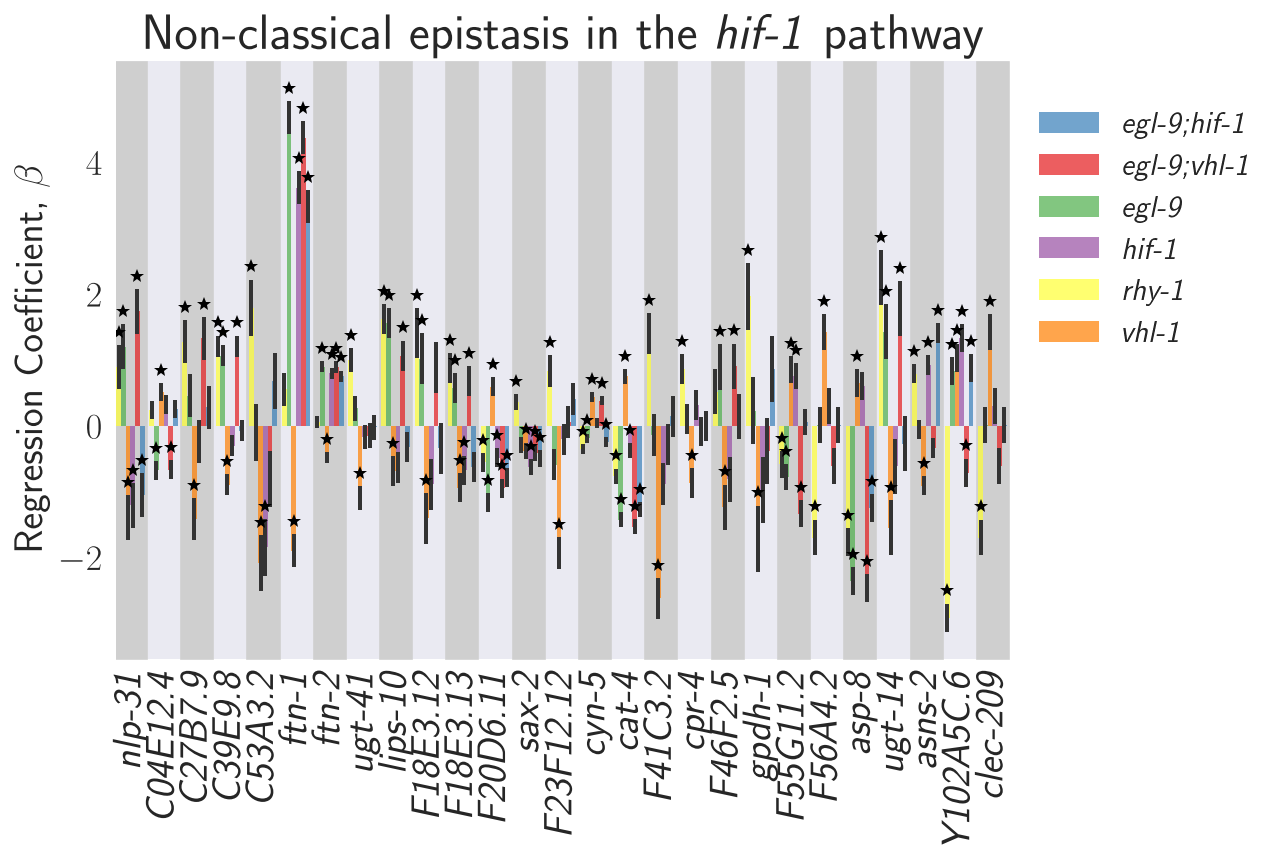

In [23]:
qPCR_plot(tidy, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='target_id',
          title='Non-classical epistasis in the \emph{hif-1} pathway',
          save='../output/hif1oh_genetics.pdf', rotation=90)

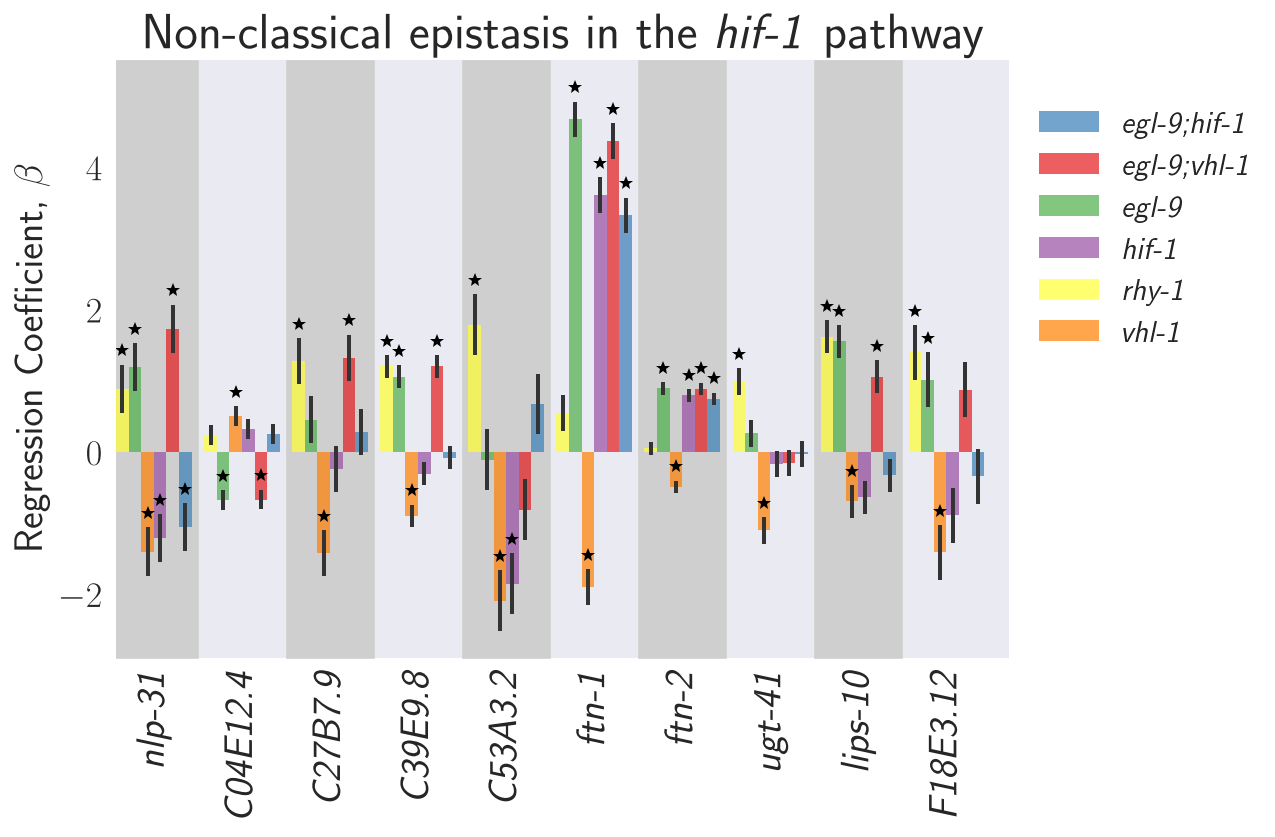

In [24]:
qPCR_plot(tidy[tidy.target_id.isin(hifoh[0:10])], genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='ext_gene',
          title='Non-classical epistasis in the \emph{hif-1} pathway',
          save='../output/hif1oh_genetics.svg', rotation=90)

In [ ]:
df1[df1.target_id.isin(hifoh)].to_csv('../output/hifoh_regulation_candidates.csv', index=False)